In [1]:
# !wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip -P .

In [2]:
# !unzip -q  concrete_crack_images_for_classification.zip -d  .

In [3]:
# !conda install pytorch=1.6.0 torchvision cudatoolkit=10.2 -c pytorch

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from torch import optim 
import numpy as np

In [5]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="data"
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[:30000]
            self.Y=self.Y[:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)    
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        
        image=Image.open(self.all_files[idx])
        y=self.Y[idx]
          
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

In [6]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# transforms.ToTensor()
#transforms.Normalize(mean, std)
#transforms.Compose([])

transform =transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean, std)])


In [7]:
dataset_train=Dataset(transform=transform,train=True)
dataset_val=Dataset(transform=transform,train=False)

In [8]:
dataset_train[0][0].shape

torch.Size([3, 227, 227])

In [9]:
size_of_image=3*227*227
size_of_image

154587

In [10]:
torch.manual_seed(0)

In [11]:
model = models.resnet18(pretrained=True)

### Change last output layer of resnet18 to 2 outputs

In [12]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Linear(512, 2)

In [13]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

In [14]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.1)

In [15]:
criterion = nn.CrossEntropyLoss()

In [16]:
dataloader_train = DataLoader(dataset_train, batch_size=1000)
dataloader_val = DataLoader(dataset_val, batch_size=1000)

In [17]:
n_train = 30000
n_test = 10000
n_epochs = 5
loss_list = []
accuracy_list = []

In [18]:
for epoch in range(n_epochs):
    print('epoch', (epoch + 1))
    loss_sublist = []
    i = 1
    model.train()
    for x, y in dataloader_train:
        print('epoch', (epoch+1), 'train', i, '/ 30')
        i += 1
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        loss_sublist.append(loss.data.item())
        loss.backward()
        optimizer.step()
    loss_list.append(np.mean(loss_sublist))
    
    correct = 0
    i = 1
    model.eval()
    for x_test, y_test in dataloader_val:
        print('epoch', (epoch+1), 'val', i, '/ 10')
        i += 1
        z = model(x_test)
        _, y_hat = torch.max(z.data, 1)
        correct += (y_hat == y_test).sum().item()
    accuracy = correct / n_test
    accuracy_list.append(accuracy)
    print()

epoch 1
epoch 1 train 1 / 30
epoch 1 train 2 / 30
epoch 1 train 3 / 30
epoch 1 train 4 / 30
epoch 1 train 5 / 30
epoch 1 train 6 / 30
epoch 1 train 7 / 30
epoch 1 train 8 / 30
epoch 1 train 9 / 30
epoch 1 train 10 / 30
epoch 1 train 11 / 30
epoch 1 train 12 / 30
epoch 1 train 13 / 30
epoch 1 train 14 / 30
epoch 1 train 15 / 30
epoch 1 train 16 / 30
epoch 1 train 17 / 30
epoch 1 train 18 / 30
epoch 1 train 19 / 30
epoch 1 train 20 / 30
epoch 1 train 21 / 30
epoch 1 train 22 / 30
epoch 1 train 23 / 30
epoch 1 train 24 / 30
epoch 1 train 25 / 30
epoch 1 train 26 / 30
epoch 1 train 27 / 30
epoch 1 train 28 / 30
epoch 1 train 29 / 30
epoch 1 train 30 / 30
epoch 1 val 1 / 10
epoch 1 val 2 / 10
epoch 1 val 3 / 10
epoch 1 val 4 / 10
epoch 1 val 5 / 10
epoch 1 val 6 / 10
epoch 1 val 7 / 10
epoch 1 val 8 / 10
epoch 1 val 9 / 10
epoch 1 val 10 / 10

epoch 2
epoch 2 train 1 / 30
epoch 2 train 2 / 30
epoch 2 train 3 / 30
epoch 2 train 4 / 30
epoch 2 train 5 / 30
epoch 2 train 6 / 30
epoch 2 train 7

### Plot the loss function

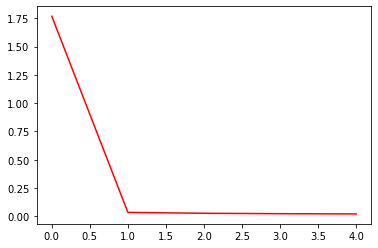

In [28]:
plt.plot(np.array(loss_list), 'r')

In [27]:
print('The accuracy : %f %%' % (np.mean(accuracy_list) * 100.))

The accuracy : 99.014000 %


In [25]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'criterion': criterion,
            }, 'model_resnet18.model')

In [22]:
### Get the first four misclassified samples

In [32]:
# https://stackoverflow.com/questions/57570043/filter-data-in-pytorch-tensor
misclass = []
model.eval()
i = 1

for x_test, y_test in dataloader_val:
    print(i)
    z = model(x_test)
    _, y_hat = torch.max(z.data, 1)
    print(y_hat != y_test)
    if (y_hat == y_test).sum().item() == 0:
        print(y_hat)
        misclass.append((i, y_hat, y_test))
    i += 1
    if misclass.__len__() == 0:
        break

1
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False

### Load Data

In [ ]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(512, 2)
#
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.1)
#
criterion = nn.CrossEntropyLoss()
#
checkpoint = torch.load('model_resnet18.model')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
loss = checkpoint['criterion']

model.eval()